In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy 
import pickle
from scipy.linalg import norm
from scipy.special import iv
from scipy.stats import beta
from tqdm.notebook import tqdm 

In [2]:
def A(d, kappa): 
    return iv(d/2, kappa) / iv(d/2-1, kappa)

def gen_beta1_vec(d): 
    return (beta.rvs(10, 10, size=d)-1/2) / (4*d)

def var_beta_vec(d): 
    
    var_single = 100 / ((20)**2 * (21)) / (4 * d)**2
    var_all = d * var_single 
    return var_all 

def psiE(x):
    assert 0 < x < 1
    return -x - np.log(1 - x)

def lambd(i, alpha, sigma2, n): 
    
    c = opt_c(alpha)
    #c = 2
    top =  c * np.log(1/alpha)
    bottom = n * sigma2 
    return min(np.sqrt(top / bottom), 0.5)

def opt_c(alpha): 
    return 2 + 8/(3*np.log(1/alpha))
    # return 8 + 32/(3 * np.log(1/alpha))

def zeta(alpha): 
    
    c = opt_c(alpha)
    return np.sqrt(9/2 + 6/np.log(1/alpha))
    return  3*np.sqrt(c) / 4 + 2 / (np.sqrt(c) * np.log(1/alpha)) + 3/(2 * np.sqrt(c))
    #return  3*np.sqrt(c) / 16 + 2 / (np.sqrt(c) * np.log(1/alpha)) + 3/(2 * np.sqrt(c))

def emp_bernstein(alpha, B, d, iters, gen_vec): 

    adk = A(d, np.sqrt(d))
    
    emp_mean_numerator = 1/2
    running_numerator = 4*B*np.sqrt(d)*adk + 2*B*np.log(1/alpha)
#    running_numerator = np.log(2/alpha)
    running_denominator = 0

    sigma_hat_top = 1/4

    width = []
    
    for i in range(1,int(iters)): 

        # Compute lambda 
        lmd = lambd(i, alpha, sigma_hat_top/i, iters)

        # Get observations 
        newX = gen_vec(d)

        # Update width 
        running_numerator += (psiE(lmd) / (2*B)) * (norm(newX - emp_mean_numerator / i))**2
        running_denominator += adk*lmd
        
        width.append(min(running_numerator/running_denominator, 1))
        
        # Update sigma and empirical mean 
        emp_mean_numerator += newX 
        sigma_hat_top += norm(newX - (emp_mean_numerator / (i+1)))**2
        
    return width 




In [6]:
d = 2 
alpha = 0.01 
widths = []
for n in tqdm(np.linspace(1000, 10e4, 19)): 
    width = emp_bernstein(alpha, 1/2, d, n, gen_beta1_vec)
    widths.append(width[-1])
    


  0%|          | 0/19 [00:00<?, ?it/s]

In [32]:
from matplotlib import rc

# Configure Matplotlib to use LaTeX
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
plt.rcParams.update({'font.size': 18})
# Use latex font 

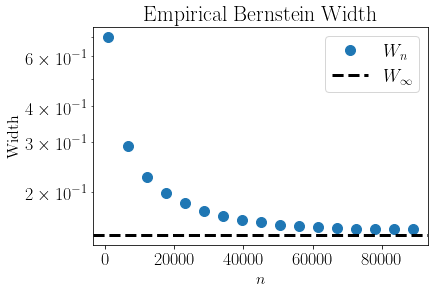

In [33]:
ns = np.linspace(1000, 10e4, 19)[:-2]
plt.plot(np.linspace(1000, 10e4, 19)[:-2], np.sqrt(ns)*np.array(widths)[:-2], 'o', label='$W_n$', ms=10)
asymp_width_eb = zeta(alpha) * np.sqrt(var_beta_vec(d) * d * np.log(1/alpha))
plt.axhline(asymp_width_eb, color='k', ls='--', lw=3, label='$W_\infty$')
plt.yscale('log')
plt.legend()
plt.xlabel('$n$', fontsize=16)
plt.ylabel('Width', fontsize=16)
plt.title('Empirical Bernstein Width')
plt.savefig('eb_width.png', bbox_inches='tight', dpi=300)